#**Import thư viện**

In [1]:
!pip install transformers
!pip install httpx

In [2]:
from google.colab import drive
import re
import httpx
import json
import random
import os
import time
import requests
import json
import asyncio
import httpx
import copy
import getpass
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

#**Cấu hình**

In [4]:
MODEL_NAME = "vinai/phobert-base"
FILE = "data_cleaned.csv"
NUM_EPOCHS = 20
BATCH_SIZE = 16
MAX_LENGTH = 128
LEARNING_RATE = 2e-5
SAMPLE_SIZE = None
BEST_MODEL_PATH = "/content/drive/MyDrive/NLP/encoder-only/my_best_encoder_model"
BEST_MODEL_PATH1 = "/content/drive/MyDrive/NLP/encoder-only/my_best_encoder_model1"
BEST_MODEL_PATH2 = "/content/drive/MyDrive/NLP/encoder-only/my_best_encoder_model2"

TRAIN_CSV = "train_data.csv"
VAL_CSV = "val_data.csv"
TEST_CSV = "test_data.csv"
target_names = ['POS', 'NEU', 'NEG']

device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if device.type == 'cuda':
  print(f"Ten GPU: {torch.cuda.get_device_name(0)}")

cuda
Ten GPU: Tesla T4


#**Kết nối Google Drive**

In [5]:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


#**EDA**

##**Kiểm tra null và độ dài bình luận**

In [6]:
df = pd.read_csv("/content/drive/MyDrive/NLP/encoder-only/data.csv")
print(df.isnull().sum())


comment           0
label             0
rate              0
Unnamed: 3    31437
dtype: int64


##**Kiểm tra độ dài bình luận**

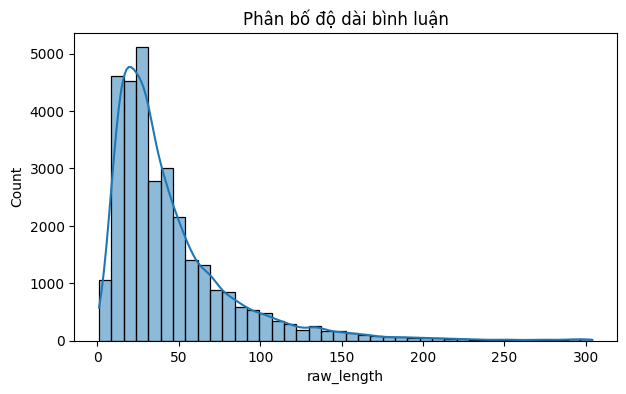

In [7]:
df["raw_length"] = df["comment"].astype(str).apply(len)

plt.figure(figsize=(7,4))
sns.histplot(df["raw_length"], bins=40, kde=True)
plt.title("Phân bố độ dài bình luận")
plt.show()


##**Kiểm tra outlier**

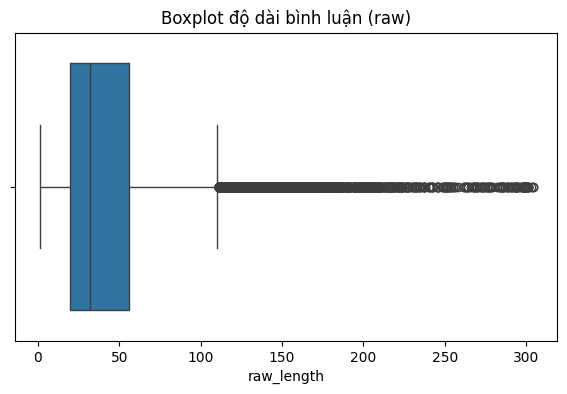

,comment,label,rate,Unnamed: 3,raw_length
574,"Cứ gần hết kẹo mút ghiền là ghé thăm shop,sẵn ...",POS,4,NaN,301
1216,"Khi nhận hàng thì lúc đầu bạn sẽ nghĩ ""omg thậ...",POS,5,NaN,304
1506,Áo kg đúng size .vai tam được .giao hàng nhanh...,NEG,2,NaN,304
1828,"Khi thấy cái váy này, mình đã quyết tâm giảm 1...",POS,5,NaN,301
14917,Chất lượng sản phẩm tuyệt vời Chất lượng sản p...,POS,5,NaN,303


In [8]:
plt.figure(figsize=(7,4))
sns.boxplot(x=df["raw_length"])
plt.title("Boxplot độ dài bình luận (raw)")
plt.show()

df[df["raw_length"] > 300].head()


##**Kiểm tra phân bố nhãn**

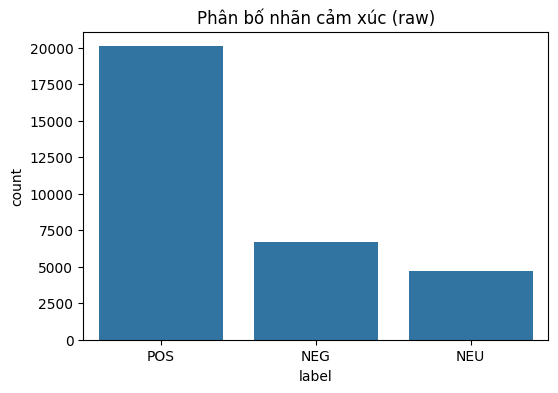

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x=df["label"])
plt.title("Phân bố nhãn cảm xúc (raw)")
plt.show()

#**Xử lý dữ liệu**

In [10]:
teencode_dict = {
    'k': 'không', 'ko': 'không', 'kh': 'không', 'hok': 'không',
    'dc': 'được', 'đc': 'được', 'dk': 'được',
    'sp': 'sản phẩm', 'san pham': 'sản phẩm',
    'tot': 'tốt', 'god': 'tốt',
    'ship': 'giao hàng', 'delivery': 'giao hàng',
    'rep': 'trả lời', 'ib': 'nhắn tin', 'shop': 'cửa hàng',
    'dt': 'điện thoại', 'fb': 'facebook', 'zalo': 'zalo',
    'nt': 'nhắn tin', 'msg': 'tin nhắn', 'r':'rồi'
}

In [11]:
def is_repetitive_spam(text):
    if not isinstance(text, str): return False
    words = text.split()
    if len(words) < 10: return False

    unique_words = set(words)
    return (len(unique_words) / len(words)) < 0.2

In [12]:
def normalize_text(text):
    if not isinstance(text, str):
        return ""
    # chuyển về chữ thường
    text = text.lower()
    # Thay thế từ viết tắt
    words = text.split()
    words = [teencode_dict.get(w, w) for w in words]
    text = ' '.join(words)

    # xóa những ký tự đặt biệt và dấu câu
    text = re.sub(r'[^\w\s]', ' ', text)
    # xóa khoảng cách dữ
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [13]:
def clean_data(
    df,
    output_path="data_cleaned_final.csv",
    min_comment_length=2,
    label_map={'NEG': 0, 'NEU': 1, 'POS': 2}
):


    initial_rows = len(df)
    print(f"Tổng số dòng ban đầu: {initial_rows}")
    df = df.drop(columns=['Unnamed: 3'], errors='ignore')

    df = df.drop_duplicates()
    duplicates_removed = initial_rows - len(df)
    print(f"Đã xóa {duplicates_removed} dòng trùng lặp.")

    spam_mask = df['comment'].apply(is_repetitive_spam)
    n_spam = spam_mask.sum()
    df = df[~spam_mask]
    print(f"Đã xóa {n_spam} dòng spam lặp lại.")

    df['comment'] = df['comment'].apply(normalize_text)

    mask_valid = df['comment'].str.len() > min_comment_length

    before_noise_filter = len(df)
    df = df[mask_valid]
    noise_removed = before_noise_filter - len(df)
    print(f"Đã xóa {noise_removed} dòng nhiễu (toàn icon, dấu chấm, quá ngắn).")

    if 'label' in df.columns:
        df['label_id'] = df['label'].map(label_map)

        missing_label_count = df['label_id'].isna().sum()
        if missing_label_count > 0:
            df = df.dropna(subset=['label_id'])
            print(f"Đã xóa {missing_label_count} dòng bị lỗi nhãn (Label không hợp lệ).")

        df['label_id'] = df['label_id'].astype(int)

    cols_to_keep = ['comment', 'label_id']

    df_final = df[cols_to_keep]
    df_final.to_csv(output_path, index=False)

    final_rows = len(df_final)


    return df_final, {
        "initial": initial_rows,
        "final": final_rows,
        "spam_removed": n_spam,
        "noise_removed": noise_removed
    }


In [14]:
df, stats = clean_data(df, output_path="data_cleaned_final.csv", min_comment_length=2, label_map={'NEG': 0, 'NEU': 1, 'POS': 2})
df.head(10)

Tổng số dòng ban đầu: 31460
Đã xóa 3982 dòng trùng lặp.
Đã xóa 16 dòng spam lặp lại.
Đã xóa 104 dòng nhiễu (toàn icon, dấu chấm, quá ngắn).


,comment,label_id
0,áo bao đẹp ạ,2
1,tuyệt vời,2
2,2day ao khong giong trong,0
3,mùi thơm bôi lên da mềm da,2
4,vải đẹp dày dặn,2
5,hàng rất đẹp rất chi là ưng ý,2
6,chất lượng sản phẩm tốt date dài,2
7,ăn nói và thái độ phục vụ tốt,2
8,đóng gói sản phẩm chắc chắn,2
9,tất sờn hết ca chưa dùng mà vay r,0


#**EDA sau khi làm sạch**

##**Phân bố độ dài câu**

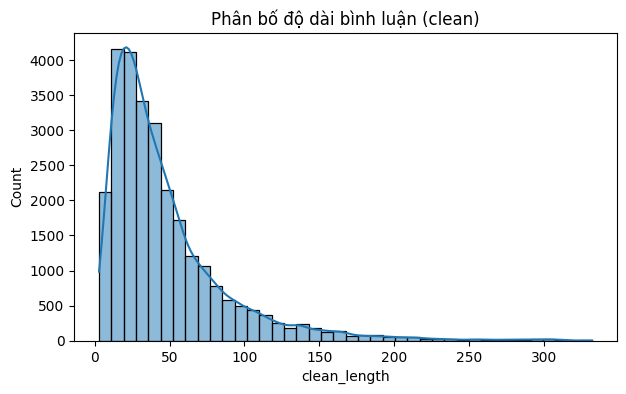

In [15]:
df["clean_length"] = df["comment"].apply(len)

plt.figure(figsize=(7,4))
sns.histplot(df["clean_length"], bins=40, kde=True)
plt.title("Phân bố độ dài bình luận (clean)")
plt.show()


##**Word Frequency (Top 30 từ)**

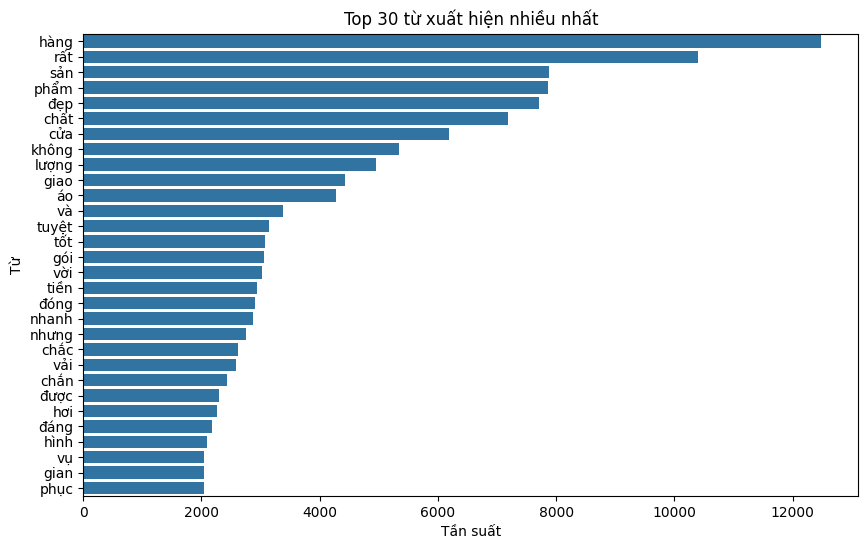

In [16]:
all_words = " ".join(df["comment"]).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)

words, counts = zip(*common_words)

plt.figure(figsize=(10,6))
sns.barplot(x=list(counts), y=list(words))
plt.title("Top 30 từ xuất hiện nhiều nhất")
plt.xlabel("Tần suất")
plt.ylabel("Từ")
plt.show()


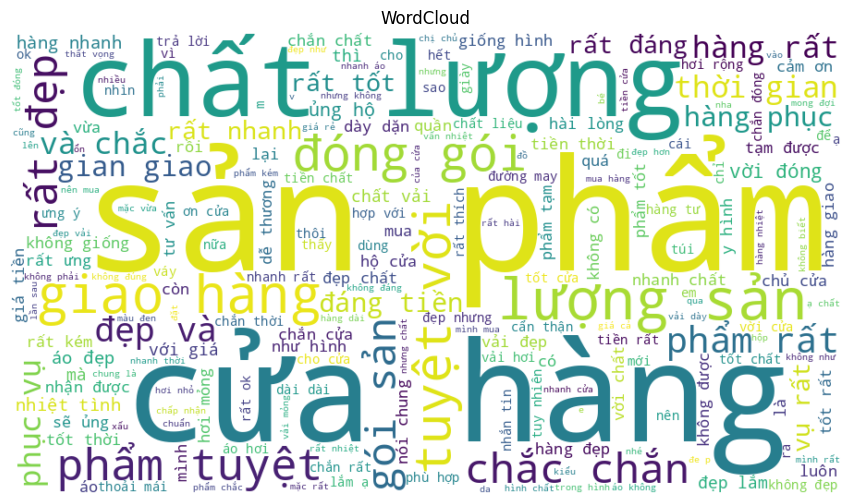

In [17]:
text = " ".join(df["comment"])

wordcloud = WordCloud(width=900, height=500, background_color="white").generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud")
plt.show()


##**Phân bố từ vựng theo từng nhãn**

In [18]:
for label in df["label_id"].unique():
    subset = df[df["label_id"] == label]
    words = " ".join(subset["comment"]).split()
    freq = Counter(words).most_common(15)

    print(f"\nTop 15 từ của nhãn {label}:")
    print(freq)



Top 15 từ của nhãn 2:
[('rất', 9246), ('hàng', 9055), ('đẹp', 6785), ('sản', 6391), ('phẩm', 6384), ('chất', 5440), ('cửa', 4662), ('lượng', 3966), ('tuyệt', 3053), ('vời', 2938), ('giao', 2923), ('và', 2812), ('tốt', 2735), ('gói', 2614), ('nhanh', 2594)]

Top 15 từ của nhãn 0:
[('không', 2914), ('hàng', 2189), ('áo', 1158), ('chất', 997), ('giao', 983), ('cửa', 967), ('phẩm', 896), ('sản', 894), ('màu', 821), ('rất', 813), ('được', 670), ('như', 654), ('vải', 630), ('mà', 629), ('nhưng', 629)]

Top 15 từ của nhãn 1:
[('hàng', 1244), ('không', 1096), ('nhưng', 764), ('chất', 741), ('hơi', 678), ('áo', 674), ('sản', 587), ('được', 583), ('phẩm', 578), ('cửa', 553), ('đẹp', 543), ('giao', 526), ('vải', 442), ('mình', 408), ('lượng', 405)]


##**Dữ liệu gốc**

In [19]:
df['label_id'] = df['label_id'].astype(int)
cols_to_keep = ['comment', 'label_id']
df.head(15)

,comment,label_id,clean_length
0,áo bao đẹp ạ,2,12
1,tuyệt vời,2,9
2,2day ao khong giong trong,0,25
3,mùi thơm bôi lên da mềm da,2,26
4,vải đẹp dày dặn,2,15
5,hàng rất đẹp rất chi là ưng ý,2,29
6,chất lượng sản phẩm tốt date dài,2,32
7,ăn nói và thái độ phục vụ tốt,2,29
8,đóng gói sản phẩm chắc chắn,2,27
9,tất sờn hết ca chưa dùng mà vay r,0,33


#**Khởi tạo Model và Tokenizer**

In [20]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config = config
)

model2 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config = config
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#**Xây dựng Class SentimentDataset**

In [21]:
class SentimentDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len):
    self.texts = texts
    self.labels =labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__ (self):
    return len(self.texts)

  def __getitem__ (self, idx):
    text = str(self.texts[idx])
    label = self.labels[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        truncation = True,
        return_tensors = 'pt'
    )

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': torch.tensor(label, dtype=torch.long)
    }

#**Chia tập dữ liệu thành train(80%), val(10%), test(10%)**

In [22]:
df_train, df_temp = train_test_split(df, test_size = 0.2,
                                     random_state = 42,
                                     stratify = df['label_id'])
df_val, df_test = train_test_split(df_temp,
                                   test_size = 0.5,
                                   random_state = 42,
                                   stratify=df_temp['label_id'])

print("Kích thước tập Train: ", len(df_train))
print("Kích thước tập Val: ", len(df_val))
print("Kích thước tập Test: ", len(df_test))

Kích thước tập Train:  21886
Kích thước tập Val:  2736
Kích thước tập Test:  2736


#**Thiết lập Dataset và DataLoader**

In [23]:
train_texts = df_train['comment'].to_numpy()
train_labels = df_train['label_id'].to_numpy()

val_texts = df_val['comment'].to_numpy()
val_labels = df_val['label_id'].to_numpy()

test_texts = df_test['comment'].to_numpy()
test_labels = df_test['label_id'].to_numpy()

df_train.to_csv(TRAIN_CSV, index = False)
df_val.to_csv(VAL_CSV, index = False)
df_test.to_csv(TEST_CSV, index = False)



train_dataset = SentimentDataset(
    texts = train_texts,
    labels = train_labels,
    tokenizer = tokenizer,
    max_len = MAX_LENGTH
)

val_dataset = SentimentDataset(
    texts = val_texts,
    labels = val_labels,
    tokenizer = tokenizer,
    max_len = MAX_LENGTH
)

test_dataset = SentimentDataset(
    texts = test_texts,
    labels = test_labels,
    tokenizer = tokenizer,
    max_len = MAX_LENGTH
)

train_loader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False
)

test_loader = DataLoader(
    test_dataset,
    batch_size = BATCH_SIZE,
    shuffle= False
)




# dữ liệu gốc
y_train = df_train['label_id'].values

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

weights_tensor = torch.tensor(class_weights, dtype=torch.float)
weights_tensor = weights_tensor.to(device)



print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

1368
171
171


#**Cấu hình API**

In [50]:
if "GEMINI_API_KEY" not in os.environ:
    os.environ["GEMINI_API_KEY"] = getpass.getpass("Nhập Google Gemini API Key: ")

MODEL_ID = "gemini-2.5-flash-lite"
API_KEY = os.environ["GEMINI_API_KEY"]
ENDPOINT = f"https://generativelanguage.googleapis.com/v1beta/models/{MODEL_ID}:generateContent?key={API_KEY}"

#**Tạo dữ liệu nhân tạo**

In [ ]:
# --- HÀM GỌI GEMINI ---
def call_gemini_paraphrase(text):
    system_prompt = """
    Bạn là một trợ lý AI chuyên tạo dữ liệu huấn luyện NLP tiếng Việt.
    Nhiệm vụ: Viết lại (paraphrase) câu bình luận dưới đây sao cho:
    1. Giữ nguyên hoàn toàn ý nghĩa và cảm xúc (Tích cực/Tiêu cực/Trung lập) của câu gốc.
    2. Thay đổi từ vựng, cấu trúc câu, sử dụng văn phong tự nhiên của người mua hàng trên Shopee/Lazada/Tiktok.
    3. CHỈ TRẢ VỀ CÂU MỚI, không bao gồm dấu ngoặc kép, không giải thích thêm.
    """

    payload = {
        "contents": [{"role": "user", "parts": [{"text": f"Câu gốc: {text}\nViết lại:"}]}],
        "system_instruction": {"parts": [{"text": system_prompt}]},
        "generation_config": {
            "temperature": 0.9,
            "max_output_tokens": 100,
        }
    }

    for attempt in range(3): # Thử lại 3 lần
        try:
            with httpx.Client(timeout=30) as client:
                response = client.post(ENDPOINT, json=payload, headers={"Content-Type": "application/json"})

            if response.status_code == 200:
                data = response.json()
                if "candidates" in data and data["candidates"]:
                    return data["candidates"][0]["content"]["parts"][0]["text"].strip()
            elif response.status_code == 429:
                print(f"Bị giới hạn Rate Limit (429). Đang đợi 10s... (Lần {attempt+1})")
                time.sleep(10) # Đợi lâu hơn nếu bị chặn
            else:
                print(f"Lỗi API {response.status_code}: {response.text}")
                return None # Lỗi khác thì bỏ qua luôn

        except Exception as e:
            print(f"Lỗi kết nối: {e}")
            time.sleep(1)
    return None

# --- QUY TRÌNH SINH DỮ LIỆU ---

if 'df_train' not in locals():
    print("CẢNH BÁO: Biến df_train chưa được định nghĩa. Hãy chạy cell split data trước!")
else:
    target_labels = [0, 1] # NEG và NEU


    samples_per_label = 500

    new_data = []

    print("--- BẮT ĐẦU SINH DỮ LIỆU (PARAPHRASING) ---")

    for label_id in target_labels:
        source_comments = df_train[df_train['label_id'] == label_id]['comment'].tolist()

        if len(source_comments) > 0:
            # Lấy mẫu có lặp lại (nếu số lượng gốc ít hơn số cần sinh)
            comments_to_process = random.choices(source_comments, k=samples_per_label)

            print(f"\n>> Đang xử lý nhãn {label_id} ({len(comments_to_process)} mẫu)...")

            # Dùng tqdm để hiện thanh tiến trình
            for original_text in tqdm(comments_to_process):
                paraphrased_text = call_gemini_paraphrase(original_text)

                if paraphrased_text:
                    clean_text = paraphrased_text.replace('"', '').replace("'", "").strip()
                    new_data.append({
                        'comment': clean_text,
                        'label_id': label_id
                    })

                time.sleep(4)

    # --- LƯU KẾT QUẢ ---
    if new_data:
        df_synthetic_safe = pd.DataFrame(new_data)
        df_synthetic_safe = df_synthetic_safe[df_synthetic_safe['comment'].str.len() > 5]

        print(f"\nHoàn tất! Đã sinh được {len(df_synthetic_safe)} mẫu.")
        print(df_synthetic_safe['label_id'].value_counts())

        df_synthetic_safe.to_csv("synthetic_data_safe.csv", index=False)
        print("Đã lưu vào file 'synthetic_data_safe.csv'")
        print(df_synthetic_safe.head())
    else:
        print("\nKhông sinh được dữ liệu nào. Hãy kiểm tra lại API Key hoặc df_train.")

#**Xây dựng các hàm đánh giá bằng gemini**

In [25]:
# @title
def call_gemini_for_scoring(system_prompt, user_prompt, max_attempts=3):
    """Gửi prompt chấm điểm đến API Gemini và yêu cầu trả về JSON."""

    # Trích xuất API Key từ ENDPOINT
    key_match = [part.split('=')[1] for part in ENDPOINT.split('?')[-1].split('&') if part.startswith('key=')]
    api_key = key_match[0] if key_match else None

    # Cấu trúc payload chuẩn cho API Gemini
    payload = {
        "contents": [{"role": "user", "parts": [{"text": user_prompt}]}],
        "system_instruction": {"parts": [{"text": system_prompt}]},
        "generation_config": {
            "response_mime_type": "application/json", # Yêu cầu định dạng JSON
        }
    }

    endpoint_base = ENDPOINT.split('?')[0]

    for attempt in range(max_attempts):
        try:
            with httpx.Client(timeout=45) as client:
                response = client.post(
                    f"{endpoint_base}?key={api_key}",
                    json=payload,
                    headers={"Content-Type": "application/json"}
                )

            if response.status_code == 200:
                data = response.json()

                if "candidates" in data and data["candidates"]:
                    text_content = data["candidates"][0]["content"]["parts"][0]["text"].strip()
                    try:
                        return json.loads(text_content)
                    except json.JSONDecodeError:
                        print(f"Lỗi phân tích JSON từ Gemini: {text_content[:100]}...")
                        return None
                return None

            elif response.status_code == 429:
                print(f"Rate limit – Đợi 10s...")
                time.sleep(10)

            else:
                print(f"API error: {response.status_code} - {response.text[:100]}...")
                return None

        except Exception as e:
            print(f"Lỗi kết nối/chung: {e}")
            time.sleep(2)

    return None

def get_test_predictions(model, data_loader, device):
    """Lấy dự đoán từ mô hình trên tập test và gán vào DataFrame."""

    # Tải lại mô hình tốt nhất và đặt chế độ đánh giá
    # model.load_state_dict(torch.load(BEST_MODEL_PATH)) # REMOVE THIS LINE
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Generating Predictions"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # Tải lại tập Test gốc để gắn kết quả
    df_test = pd.read_csv(TEST_CSV)
    df_test['true_label_id'] = all_labels
    df_test['predicted_label_id'] = all_preds

    return df_test

In [26]:
# @title
def llm_evaluate_classification(df_results, sample_size=30, random_seed=42):
    # 3.1. Lọc ra các trường hợp dự đoán SAI (Misclassified)
    df_misclassified = df_results[df_results['true_label_id'] != df_results['predicted_label_id']].copy()

    if len(df_misclassified) == 0:
        print("Mô hình quá tốt! Không có lỗi sai để đánh giá LLM.")
        return pd.DataFrame()

    # Chọn ngẫu nhiên N mẫu sai để chấm điểm LLM (Đánh giá trên mẫu nhỏ)
    n_samples = min(sample_size, len(df_misclassified))
    df_sample = df_misclassified.sample(n=n_samples, random_state=random_seed)

    # Định nghĩa bản đồ nhãn
    label_map_reverse = {0: "NEG (Tiêu cực)", 1: "NEU (Trung lập)", 2: "POS (Tích cực)"}

    llm_scores = []

    # --- PROMPT VÀ TIÊU CHÍ CHẤM ĐIỂM ---
    SYSTEM_PROMPT = "Bạn là chuyên gia phân loại cảm xúc. Nhiệm vụ của bạn là đánh giá lỗi sai của một mô hình AI."

    CRITERIA_PROMPT = (
        "Đánh giá lý do mô hình phân loại bị sai: \n"
        "1. Độ khó (1-5): Đánh giá độ khó của bình luận Gốc. (1: Rất dễ, 5: Rất khó/Mơ hồ). \n"
        "2. Lỗi do Dữ liệu/Mơ hồ (0/1): Nếu Độ khó >= 4 (Mơ hồ), gán 1 (Lỗi do Dữ liệu/Mơ hồ). Ngược lại, gán 0 (Lỗi do Mô hình).\n"
        "3. Lý do: Giải thích tại sao bình luận này gây nhầm lẫn hoặc tại sao mô hình sai sót.\n"
        "TRẢ LỜI ĐÚNG ĐỊNH DẠNG JSON: {'Độ_Khó': [1-5], 'Lỗi_Do_Dữ_Liệu': [0 hoặc 1], 'Lý_do': '...'}"
    )

    for _, row in tqdm(df_sample.iterrows(), desc=f"LLM Scoring ({n_samples} mẫu)"):
        comment = row['comment']
        true_label = label_map_reverse[row['true_label_id']]
        predicted_label = label_map_reverse[row['predicted_label_id']]

        user_prompt = f"""
            {CRITERIA_PROMPT}
            ---
            Bình luận Gốc: "{comment}"
            Nhãn Đúng (True Label): {true_label}
            Nhãn Mô hình Dự đoán (Predicted Label): {predicted_label}
        """

        score_result = call_gemini_for_scoring(SYSTEM_PROMPT, user_prompt)

        if score_result:
            score_result.update({
                'comment': comment,
                'true_label': true_label,
                'predicted_label': predicted_label
            })
            llm_scores.append(score_result)

    df_scored = pd.DataFrame(llm_scores)
    df_scored.to_csv("llm_evaluation_misclassified.csv", index=False)

    print("\n--- ĐÁNH GIÁ LLM HOÀN TẤT ---")
    print(f"Đã chấm điểm và lưu {len(df_scored)} mẫu vào 'llm_evaluation_misclassified.csv'.")

    return df_scored

#**Huấn luyện mô hình**

##**Hàm đánh giá mô hình**

In [27]:
# @title
def eval_model(model, data_loader, device, target_names):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_loss += outputs.loss.item()

            _, preds = torch.max(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)

    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(
        all_labels,
        all_preds,
        target_names=target_names,
        zero_division=0
    )
    print(f"Accuracy: {accuracy} - Report: {report}")
    return accuracy, report, avg_loss

##**Hàm huấn luyện mô hình**

In [30]:
def train(model, train_loader, val_loader, NUM_EPOCHS, optimizer, target_names, BEST_MODEL_PATH, class_weights, patience=3):
    best_val_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict()) # Lưu trọng số tốt nhất
    early_stopping_counter = 0 # Đếm số lần không cải thiện

    # Khai báo hàm loss với trọng số
    criterion = torch.nn.CrossEntropyLoss(weight= class_weights)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    print(f"Bắt đầu huấn luyện... (Patience={patience})")

    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        model.train()

        total_train_loss = 0
        correct_train_preds = 0
        total_samples = 0

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            model.zero_grad()

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            loss = criterion(logits, labels)

            total_train_loss += loss.item()

            _, preds = torch.max(logits, dim=1)
            correct_train_preds += torch.sum(preds == labels).item()
            total_samples += len(labels)

            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = correct_train_preds / total_samples

        print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")

        # val
        val_accuracy, val_report, val_loss = eval_model(model, val_loader, device, target_names)
        print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_accuracy:.4f}")

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_accuracy)


        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

            # Lưu model vào file
            model.save_pretrained(BEST_MODEL_PATH)
            tokenizer.save_pretrained(BEST_MODEL_PATH)
            print("Đã lưu model tốt nhất mới!")

            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

            if early_stopping_counter >= patience:
                print(f"Dừng sớm tại Epoch {epoch+1} vì không cải thiện sau {patience} epochs.")
                break

    model.load_state_dict(best_model_wts)
    print(f"Hoàn tất! Best Val Accuracy: {best_val_accuracy:.4f}")

    return history

##**Hàm dự đoán**

In [31]:
# @title
def predict(text, model, tokenizer, device, MAX_LENGTH):
  # Ensure the model is on the correct device
  model.to(device)
  model.eval()
  encoding = tokenizer.encode_plus(
      text,
      add_special_tokens = True,
      max_length = MAX_LENGTH,
      truncation = True,
      padding = 'max_length',
      return_attention_mask = True,
      return_tensors = 'pt'
  )

  input_ids = encoding['input_ids'].to(device)
  attention_mask = encoding['attention_mask'].to(device)

  with torch.no_grad():
    outputs = model(input_ids, attention_mask)
    _, preds = torch.max(outputs.logits, dim = 1)


  if preds.item() == 0:
    return "Negative"
  elif preds.item() == 1:
    return "Neutral"
  else:
    return "Positive"

##**Hàm vẽ biểu đồ**

In [32]:
# @title
def plot_history(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Biểu đồ Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # Biểu đồ Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.show()

#**Huấn luyện dữ liệu gốc**

##**Huấn luyện**

In [33]:
# Tạo trọng số cho 3 lớp
manual_weights_values = [1.2, 3.5, 0.8]
weights_tensor_manual = torch.tensor(manual_weights_values, dtype=torch.float).to(device)
# Load model gốc
model_original = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
model_original.to(device)
# Tối ưu hóa
optimizer_original = AdamW(model_original.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bắt đầu huấn luyện... (Patience=3)

Epoch 1/20


Training Epoch 1:   0%|          | 0/1368 [00:00<?, ?it/s]

Train Loss: 0.9513 | Train Acc: 0.5682


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7430555555555556 - Report:               precision    recall  f1-score   support

         POS       0.64      0.88      0.74       640
         NEU       0.32      0.29      0.30       437
         NEG       0.92      0.81      0.86      1659

    accuracy                           0.74      2736
   macro avg       0.63      0.66      0.63      2736
weighted avg       0.76      0.74      0.74      2736

Val Loss:   0.6321 | Val Acc:   0.7431
Đã lưu model tốt nhất mới!

Epoch 2/20


Training Epoch 2:   0%|          | 0/1368 [00:00<?, ?it/s]

Train Loss: 0.7641 | Train Acc: 0.6960


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7839912280701754 - Report:               precision    recall  f1-score   support

         POS       0.74      0.78      0.76       640
         NEU       0.42      0.40      0.41       437
         NEG       0.89      0.89      0.89      1659

    accuracy                           0.78      2736
   macro avg       0.68      0.69      0.69      2736
weighted avg       0.78      0.78      0.78      2736

Val Loss:   0.5665 | Val Acc:   0.7840
Đã lưu model tốt nhất mới!

Epoch 3/20


Training Epoch 3:   0%|          | 0/1368 [00:00<?, ?it/s]

Train Loss: 0.7187 | Train Acc: 0.7222


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.758406432748538 - Report:               precision    recall  f1-score   support

         POS       0.71      0.80      0.75       640
         NEU       0.37      0.46      0.41       437
         NEG       0.92      0.82      0.87      1659

    accuracy                           0.76      2736
   macro avg       0.67      0.69      0.68      2736
weighted avg       0.79      0.76      0.77      2736

Val Loss:   0.5867 | Val Acc:   0.7584

Epoch 4/20


Training Epoch 4:   0%|          | 0/1368 [00:00<?, ?it/s]

Train Loss: 0.6912 | Train Acc: 0.7332


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7777777777777778 - Report:               precision    recall  f1-score   support

         POS       0.74      0.76      0.75       640
         NEU       0.41      0.50      0.45       437
         NEG       0.92      0.86      0.89      1659

    accuracy                           0.78      2736
   macro avg       0.69      0.71      0.70      2736
weighted avg       0.80      0.78      0.79      2736

Val Loss:   0.5660 | Val Acc:   0.7778

Epoch 5/20


Training Epoch 5:   0%|          | 0/1368 [00:00<?, ?it/s]

Train Loss: 0.6681 | Train Acc: 0.7473


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7832602339181286 - Report:               precision    recall  f1-score   support

         POS       0.69      0.85      0.76       640
         NEU       0.42      0.35      0.38       437
         NEG       0.92      0.87      0.89      1659

    accuracy                           0.78      2736
   macro avg       0.67      0.69      0.68      2736
weighted avg       0.78      0.78      0.78      2736

Val Loss:   0.5697 | Val Acc:   0.7833
Dừng sớm tại Epoch 5 vì không cải thiện sau 3 epochs.
Hoàn tất! Best Val Accuracy: 0.7840


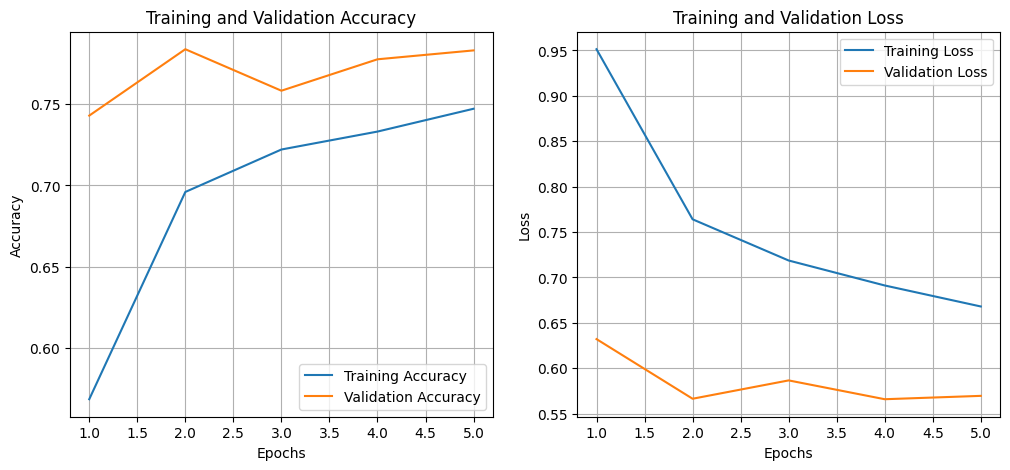

In [34]:
# # Huấn luyện mô hình
# history_original = train(
#     model_original,
#     train_loader,
#     val_loader,
#     NUM_EPOCHS,
#     optimizer_original,
#     target_names,
#     BEST_MODEL_PATH,
#     class_weights=weights_tensor_manual
# )
history_original = train(
    model=model_original,
    train_loader=train_loader,
    val_loader=val_loader,
    NUM_EPOCHS=20,
    optimizer=optimizer_original,
    target_names=target_names,
    BEST_MODEL_PATH=BEST_MODEL_PATH,
    class_weights=weights_tensor,
    patience=3
)
# Vẽ biểu đồ
plot_history(history_original)

##**Tải model gốc**

In [35]:
tokenizer = AutoTokenizer.from_pretrained(BEST_MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(BEST_MODEL_PATH)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

##**Đánh giá trên tập dữ liệu kiểm thử**

In [36]:
test_accuracy, test_report, _ = eval_model(
    model,
    test_loader,
    device,
    target_names
)

print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:\n")
print(test_report)

Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7763157894736842 - Report:               precision    recall  f1-score   support

         POS       0.74      0.73      0.74       640
         NEU       0.41      0.40      0.40       438
         NEG       0.88      0.89      0.89      1658

    accuracy                           0.78      2736
   macro avg       0.68      0.67      0.68      2736
weighted avg       0.77      0.78      0.77      2736

Final Test Accuracy: 0.7763

Test Classification Report:

              precision    recall  f1-score   support

         POS       0.74      0.73      0.74       640
         NEU       0.41      0.40      0.40       438
         NEG       0.88      0.89      0.89      1658

    accuracy                           0.78      2736
   macro avg       0.68      0.67      0.68      2736
weighted avg       0.77      0.78      0.77      2736



##**Đánh giá bằng LLMs**

In [37]:
df_preds = get_test_predictions(model, test_loader, device)
llm_evaluation_results = llm_evaluate_classification(df_preds, sample_size=30)
print(llm_evaluation_results)

df_ket_qua = pd.read_csv("llm_evaluation_misclassified.csv")


excel_filename = "/content/drive/MyDrive/NLP/encoder-only/ket_qua_danh_gia_gemini.xlsx"
df_ket_qua.to_excel(excel_filename, index=False)

Generating Predictions:   0%|          | 0/171 [00:00<?, ?it/s]

LLM Scoring (30 mẫu): 0it [00:00, ?it/s]

API error: 503 - {
  "error": {
    "code": 503,
    "message": "The model is overloaded. Please try again later.",
 ...
API error: 503 - {
  "error": {
    "code": 503,
    "message": "The model is overloaded. Please try again later.",
 ...
Lỗi phân tích JSON từ Gemini: {'Độ_Khó': 3, 'Lỗi_Do_Dữ_Liệu': 0, 'Lý_do': 'Bình luận có hàm ý tiêu cực về kích thước sản phẩm ("hơ...
API error: 503 - {
  "error": {
    "code": 503,
    "message": "The model is overloaded. Please try again later.",
 ...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Lỗi phân tích JSON từ Gemini: {'Độ_Khó': 3, 'Lỗi_Do_Dữ_Liệu': 0, 'Lý_do': 'Bình luận có cả yếu tố tích cực (đóng gói đẹp và chắc c...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limi

#**Huấn luyện mô hình kết hợp dữ liệu gốc và synthetic**

##**Đọc và làm sạch dữ liệu**

In [39]:
synthetic_path = "/content/drive/MyDrive/NLP/encoder-only/synthetic_data.csv"
df_synthetic_raw = pd.read_csv(synthetic_path)
df_synthetic, _ = clean_data(df_synthetic_raw, output_path="data_cleaned_synthetic.csv")
df_synthetic['label_id'] = df_synthetic['label_id'].astype(int)
cols_to_keep = ['comment', 'label_id']
df_synthetic.head(5)


Tổng số dòng ban đầu: 2825
Đã xóa 15 dòng trùng lặp.
Đã xóa 0 dòng spam lặp lại.
Đã xóa 0 dòng nhiễu (toàn icon, dấu chấm, quá ngắn).


,comment,label_id
0,cửa hàng gửi nhầm sz rùi ạ huhu,0
1,ốp bị xước nha cửa hàng,0
2,giá chát quá trời cửa hàng khác rẻ hơn nhiều,0
3,ủa rồi sao không thấy cửa hàng trả lời tin nhắ...,0
4,áo này làm mình hơi hụt hẫng á,0


##**Kết hợp dữ liệu**

In [40]:
df_combine = pd.concat([df_train[cols_to_keep], df_synthetic], axis = 0, ignore_index= True)
print(df_combine['label_id'].value_counts())
df_combine.head(5)

label_id
2    13268
0     6538
1     4890
Name: count, dtype: int64


,comment,label_id
0,không mềm lắm,1
1,mùi chanh hay nhất,1
2,quần chất thích lắm ạ,2
3,màu vải ít giống với hình ảnh thực tế,0
4,áo đẹp mặc rất mát giá cả cũng ok,2


##**Chuẩn bị tài nguyên**

In [41]:
texts_combine = df_combine['comment'].to_numpy()
labels_combine = df_combine['label_id'].to_numpy()
dataset_combine = SentimentDataset(
    texts = texts_combine,
    labels = labels_combine,
    tokenizer =tokenizer,
    max_len = MAX_LENGTH)

loader_combine = DataLoader(
    dataset_combine,
    batch_size=BATCH_SIZE,
    shuffle=True)


classes_combine= np.unique(labels_combine)
weights_combine = compute_class_weight(
    class_weight='balanced',
    classes=classes_combine,
    y=labels_combine)


weights_tensor_combine = torch.tensor(
    weights_combine,
    dtype=torch.float).to(device)


In [42]:
# Tạo trọng số cho 3 lớp
manual_weights_values = [1.2, 3.0, 0.8]
weights_tensor_manual1 = torch.tensor(manual_weights_values, dtype=torch.float).to(device)
# Load model gốc
model_combine = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
model_combine.to(device)
# Tối ưu hóa
optimizer_combine = AdamW(model_combine.parameters(), lr=1e-5, weight_decay=0.01)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##**Huấn luyện mô hình**

Bắt đầu huấn luyện... (Patience=3)

Epoch 1/20


Training Epoch 1:   0%|          | 0/1544 [00:00<?, ?it/s]

Train Loss: 1.0465 | Train Acc: 0.4581


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7302631578947368 - Report:               precision    recall  f1-score   support

         POS       0.68      0.69      0.69       640
         NEU       0.33      0.30      0.32       437
         NEG       0.84      0.86      0.85      1659

    accuracy                           0.73      2736
   macro avg       0.62      0.62      0.62      2736
weighted avg       0.72      0.73      0.73      2736

Val Loss:   0.6800 | Val Acc:   0.7303
Đã lưu model tốt nhất mới!

Epoch 2/20


Training Epoch 2:   0%|          | 0/1544 [00:00<?, ?it/s]

Train Loss: 0.8294 | Train Acc: 0.6493


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7521929824561403 - Report:               precision    recall  f1-score   support

         POS       0.70      0.78      0.74       640
         NEU       0.36      0.42      0.39       437
         NEG       0.91      0.83      0.87      1659

    accuracy                           0.75      2736
   macro avg       0.66      0.68      0.66      2736
weighted avg       0.77      0.75      0.76      2736

Val Loss:   0.5966 | Val Acc:   0.7522
Đã lưu model tốt nhất mới!

Epoch 3/20


Training Epoch 3:   0%|          | 0/1544 [00:00<?, ?it/s]

Train Loss: 0.7530 | Train Acc: 0.6933


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7620614035087719 - Report:               precision    recall  f1-score   support

         POS       0.70      0.80      0.75       640
         NEU       0.37      0.42      0.40       437
         NEG       0.92      0.84      0.88      1659

    accuracy                           0.76      2736
   macro avg       0.66      0.69      0.67      2736
weighted avg       0.78      0.76      0.77      2736

Val Loss:   0.5881 | Val Acc:   0.7621
Đã lưu model tốt nhất mới!

Epoch 4/20


Training Epoch 4:   0%|          | 0/1544 [00:00<?, ?it/s]

Train Loss: 0.7107 | Train Acc: 0.7143


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7657163742690059 - Report:               precision    recall  f1-score   support

         POS       0.74      0.77      0.75       640
         NEU       0.38      0.47      0.42       437
         NEG       0.91      0.84      0.88      1659

    accuracy                           0.77      2736
   macro avg       0.68      0.69      0.68      2736
weighted avg       0.79      0.77      0.77      2736

Val Loss:   0.5811 | Val Acc:   0.7657
Đã lưu model tốt nhất mới!

Epoch 5/20


Training Epoch 5:   0%|          | 0/1544 [00:00<?, ?it/s]

Train Loss: 0.6860 | Train Acc: 0.7283


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7722953216374269 - Report:               precision    recall  f1-score   support

         POS       0.69      0.84      0.76       640
         NEU       0.39      0.36      0.37       437
         NEG       0.92      0.85      0.88      1659

    accuracy                           0.77      2736
   macro avg       0.66      0.69      0.67      2736
weighted avg       0.78      0.77      0.77      2736

Val Loss:   0.5812 | Val Acc:   0.7723
Đã lưu model tốt nhất mới!

Epoch 6/20


Training Epoch 6:   0%|          | 0/1544 [00:00<?, ?it/s]

Train Loss: 0.6649 | Train Acc: 0.7393


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7796052631578947 - Report:               precision    recall  f1-score   support

         POS       0.72      0.81      0.77       640
         NEU       0.40      0.36      0.38       437
         NEG       0.90      0.88      0.89      1659

    accuracy                           0.78      2736
   macro avg       0.67      0.68      0.68      2736
weighted avg       0.78      0.78      0.78      2736

Val Loss:   0.5550 | Val Acc:   0.7796
Đã lưu model tốt nhất mới!

Epoch 7/20


Training Epoch 7:   0%|          | 0/1544 [00:00<?, ?it/s]

Train Loss: 0.6454 | Train Acc: 0.7472


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7817982456140351 - Report:               precision    recall  f1-score   support

         POS       0.69      0.85      0.76       640
         NEU       0.41      0.34      0.37       437
         NEG       0.91      0.87      0.89      1659

    accuracy                           0.78      2736
   macro avg       0.67      0.69      0.68      2736
weighted avg       0.78      0.78      0.78      2736

Val Loss:   0.5714 | Val Acc:   0.7818
Đã lưu model tốt nhất mới!

Epoch 8/20


Training Epoch 8:   0%|          | 0/1544 [00:00<?, ?it/s]

Train Loss: 0.6346 | Train Acc: 0.7548


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7909356725146199 - Report:               precision    recall  f1-score   support

         POS       0.74      0.79      0.76       640
         NEU       0.43      0.38      0.41       437
         NEG       0.89      0.90      0.90      1659

    accuracy                           0.79      2736
   macro avg       0.69      0.69      0.69      2736
weighted avg       0.78      0.79      0.79      2736

Val Loss:   0.5415 | Val Acc:   0.7909
Đã lưu model tốt nhất mới!

Epoch 9/20


Training Epoch 9:   0%|          | 0/1544 [00:00<?, ?it/s]

Train Loss: 0.6236 | Train Acc: 0.7598


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7708333333333334 - Report:               precision    recall  f1-score   support

         POS       0.75      0.77      0.76       640
         NEU       0.39      0.51      0.44       437
         NEG       0.92      0.84      0.88      1659

    accuracy                           0.77      2736
   macro avg       0.69      0.71      0.69      2736
weighted avg       0.80      0.77      0.78      2736

Val Loss:   0.6001 | Val Acc:   0.7708

Epoch 10/20


Training Epoch 10:   0%|          | 0/1544 [00:00<?, ?it/s]

Train Loss: 0.6099 | Train Acc: 0.7652


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7730263157894737 - Report:               precision    recall  f1-score   support

         POS       0.73      0.78      0.75       640
         NEU       0.40      0.47      0.43       437
         NEG       0.92      0.85      0.88      1659

    accuracy                           0.77      2736
   macro avg       0.68      0.70      0.69      2736
weighted avg       0.79      0.77      0.78      2736

Val Loss:   0.5645 | Val Acc:   0.7730

Epoch 11/20


Training Epoch 11:   0%|          | 0/1544 [00:00<?, ?it/s]

Train Loss: 0.5982 | Train Acc: 0.7719


Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7774122807017544 - Report:               precision    recall  f1-score   support

         POS       0.70      0.82      0.76       640
         NEU       0.40      0.38      0.39       437
         NEG       0.91      0.86      0.89      1659

    accuracy                           0.78      2736
   macro avg       0.67      0.69      0.68      2736
weighted avg       0.78      0.78      0.78      2736

Val Loss:   0.5908 | Val Acc:   0.7774
Dừng sớm tại Epoch 11 vì không cải thiện sau 3 epochs.
Hoàn tất! Best Val Accuracy: 0.7909


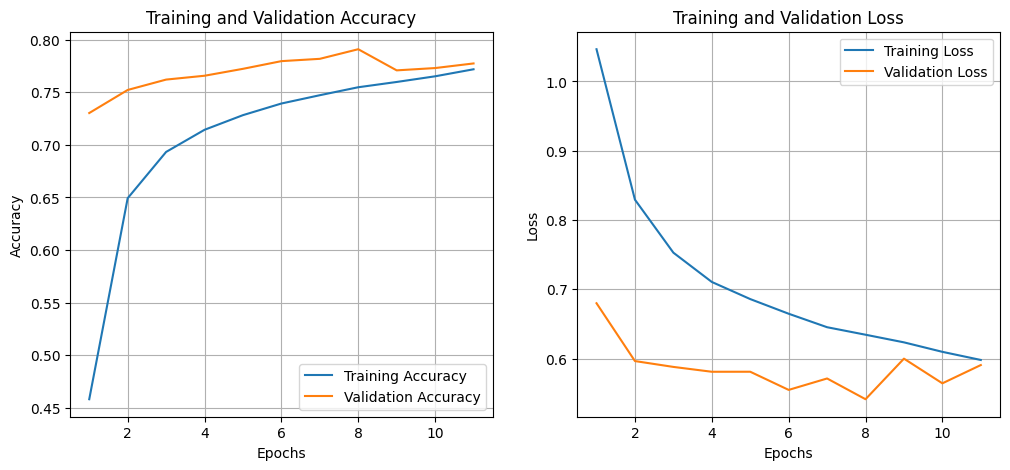

In [43]:
# # Huấn luyện mô hình
# history_original = train(
#     model_combine,
#     loader_combine,
#     val_loader,
#     NUM_EPOCHS,
#     optimizer_combine,
#     target_names,
#     BEST_MODEL_PATH2,
#     class_weights=weights_tensor_manual1,

# )
history_combine = train(
    model=model_combine,
    train_loader=loader_combine,
    val_loader=val_loader,
    NUM_EPOCHS=20,
    optimizer=optimizer_combine,
    target_names=target_names,
    BEST_MODEL_PATH=BEST_MODEL_PATH2,
    class_weights=weights_tensor_combine,
    patience=3
)

# Vẽ biểu đồ
plot_history(history_combine)

##**Tải mô hình**

In [44]:
tokenizer_combine = AutoTokenizer.from_pretrained(BEST_MODEL_PATH2)
model_combine = AutoModelForSequenceClassification.from_pretrained(BEST_MODEL_PATH2)
model_combine.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

##**Đánh giá mô hình trên tập kiểm thử**

In [45]:
test_accuracy_combine, test_report_combine, _ = eval_model(
    model_combine,
    test_loader,
    device,
    target_names
)

print(f"Final Test Accuracy: {test_accuracy_combine:.4f}")
print("\nTest Classification Report:\n")
print(test_report_combine)

Evaluating:   0%|          | 0/171 [00:00<?, ?it/s]

Accuracy: 0.7887426900584795 - Report:               precision    recall  f1-score   support

         POS       0.75      0.78      0.77       640
         NEU       0.44      0.39      0.41       438
         NEG       0.88      0.90      0.89      1658

    accuracy                           0.79      2736
   macro avg       0.69      0.69      0.69      2736
weighted avg       0.78      0.79      0.78      2736

Final Test Accuracy: 0.7887

Test Classification Report:

              precision    recall  f1-score   support

         POS       0.75      0.78      0.77       640
         NEU       0.44      0.39      0.41       438
         NEG       0.88      0.90      0.89      1658

    accuracy                           0.79      2736
   macro avg       0.69      0.69      0.69      2736
weighted avg       0.78      0.79      0.78      2736



##**Đánh giá bằng LLMS**

In [49]:
df_preds_combine = get_test_predictions(model_combine, test_loader, device)
llm_evaluation_results = llm_evaluate_classification(df_preds_combine, sample_size=30)
print(llm_evaluation_results)

df_ket_qua = pd.read_csv("llm_evaluation_misclassified.csv")

excel_filename = "/content/drive/MyDrive/NLP/encoder-only/ket_qua_danh_gia_gemini2.xlsx"
df_ket_qua.to_excel(excel_filename, index=False)

Generating Predictions:   0%|          | 0/171 [00:00<?, ?it/s]

LLM Scoring (30 mẫu): 0it [00:00, ?it/s]

Lỗi phân tích JSON từ Gemini: {'Độ_Khó': 2, 'Lỗi_Do_Dữ_Liệu': 0, 'Lý_do': 'Bình luận chỉ ra chất lượng vải mỏng, đây là một đặc đi...
Lỗi phân tích JSON từ Gemini: {'Độ_Khó': 2, 'Lỗi_Do_Dữ_Liệu': 0, 'Lý_do': 'Bình luận ngắn gọn, có thể diễn giải là trung lập hoặc ...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Lỗi phân tích JSON từ Gemini: {'Độ_Khó': 2, 'Lỗi_Do_Dữ_Liệu': 0, 'Lý_do': 'Bình luận này có thể bị nhầm lẫn với việc không thích m...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s...
Rate limit – Đợi 10s..

#**Kiểm thử**

In [51]:
predict("tôi rất thích món này ", model, tokenizer, device, MAX_LENGTH)

'Positive'

In [52]:
predict("sản phẩm không thể không thích sản phẩm này", model_combine, tokenizer, device, MAX_LENGTH)

'Negative'